In [1]:
import sys, platform, os
from matplotlib import pyplot as plt
import Fisher
import numpy as np
import camb
import scipy
from scipy import linalg
import pandas as pd
from matplotlib.patches import Ellipse
from collections import OrderedDict
import healpy as hp
import astropy.units as u
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import fishchips.util
import pickle
from so_models_v3 import SO_Noise_Calculator_Public_v3_1_1 as so_models

In [2]:
fiducial_values = {
    'ombh2': 0.0224,
    'omch2': 0.1201,
    'H0': 67.74, 
    #'thetaMC': 0.01040670741042047,
    'thetastar': 1.0411*(1/100),
    'As': 2.101 * (10**(-9)),
    'ns': 0.9660,
    'tau': 0.0543
}

# Other constants
cmboutscale = 7.43e12
mode = 2
lmax = 5000
ellrange = np.arange(lmax+1)
L = 20 # Binsize
fsky = 0.4
s2s = [31000, 17000, 1500, 230, 39, 100]
t_obs = 5 # Years
lat = so_models.SOLatV3point1(mode, el = 50.)
latbands = lat.get_bands()
N_bands = len(latbands)
FWHMs = [7.4, 5.1, 2.2, 1.4, 1.0, 0.9] * u.arcmin
frequencies = [27, 39, 93, 145, 225, 280] * u.GHz

bands = Fisher.get_bin_def(bin_width = L,
                    lmax = lmax)['cmb_tt']
band_cents = [bands[i][1] - (bands[i][1] - 
                             bands[i][0]) / 2 
              for i in range(len(bands))]
noise_beams = [hp.gauss_beam(i.to(u.rad).value, lmax) for i in FWHMs]

Dl = (ellrange * (ellrange + 1)) / (2 * np.pi)
Db = [np.mean(Dl[bands[i][0] : bands[i][1]]) 
      for i in range((len(bands)))]

colors = ['b', 'r', 'g', 'm', 'k', 'y']

Fisher_params = ['thetastar', 'ombh2', 'omch2', 'As', 'tau', 'ns']
param_steps   = [0.1 * fiducial_values['thetastar'] / 2,
                 0.1 * fiducial_values['ombh2'] / 2,
                 0.1 * fiducial_values['omch2'] / 2,
                 0.1 * fiducial_values['As'] / 2,
                 0.1 * fiducial_values['tau'] / 2,
                 0.05]
N_params = len(Fisher_params)

In [3]:
# SO 
SO_Params = camb.set_params(#cosmomc_theta = fiducial_values['thetaMC'],
                            thetastar     = fiducial_values['thetastar'],
                            ombh2         = fiducial_values['ombh2'],
                            omch2         = fiducial_values['omch2'],
                            As            = fiducial_values['As'],
                            tau           = fiducial_values['tau'],
                            ns            = fiducial_values['ns'],
                            lmax          = lmax,
                            WantTransfer  = False,
                            dark_energy_model = 'fluid')
SO_results = camb.get_results(SO_Params)
SO_powers  = SO_results.get_cmb_power_spectra(SO_Params,
                                              lmax = lmax)
# Power Spectra
ClTT_SO = SO_powers['unlensed_total'][:, 0]

CbTT_SO = [np.mean(ClTT_SO[bands[i][0]: bands[i][1]], axis = 0) 
           for i in range(len(bands))]
CbTT_SO_vecs = [cmboutscale * ClTT_SO[bands[i][0]: bands[i][1]] 
                for i in range(len(bands))]

In [4]:
# Noise
Nb_TT_T = [Fisher.Cl_Noise(fsky, Bl = noise_beams[i], t_obs = t_obs,
                s2 = s2s[i], bands = bands) for i in range(len(FWHMs))]
# Parameter Derivatives
derivsCl = [Fisher.bandderivs(fiducial_values, 
                       Fisher_params[param], 
                       param_steps[param])
            for param in range(N_params)]
partialCl = pd.DataFrame(derivsCl)

In [5]:
# Diagonal Covariance from bandpowers
C_teg = Fisher.DeltCb(band_cents, CbTT_SO, Nb_TT_T, '27')

band_freqs = [27, 39, 93, 145, 225, 280]
C_tegs = [Fisher.DeltCb(band_cents, CbTT_SO, Nb_TT_T, str(band_freqs[i]))
          for i in range(N_bands)]

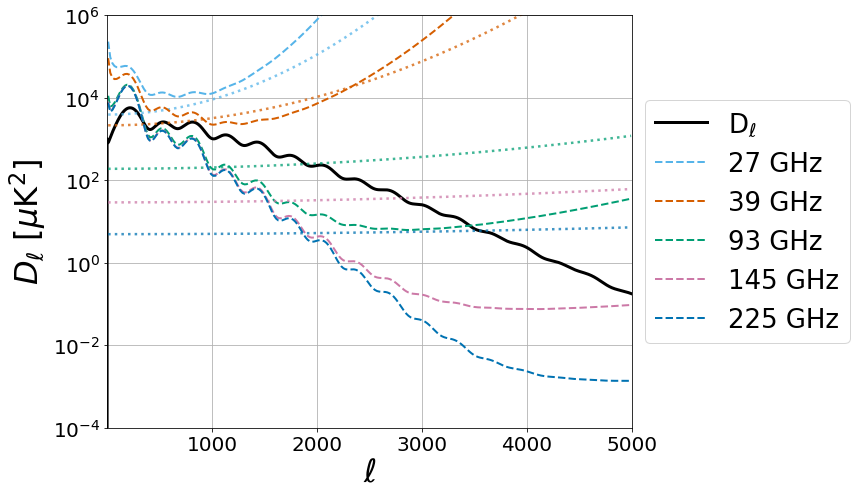

In [6]:
plt.figure(figsize = (12, 7))

plt.semilogy(ClTT_SO * cmboutscale, color = 'black', label = 'D$_\ell$', lw = 3.)
#plt.semilogy(ClTT_P[:len(Dl)] * Dl * cmboutscale)
colors = ['#56B4E9', '#D55E00', '#009E73', '#CC79A7', '#0072B2', '#F0E442']

for i in range(5):

    plt.semilogy(np.array(band_cents), Nb_TT_T[i], 
                 color = colors[i], ls = 'dotted', 
                 lw = 2.5, alpha = 0.75)
    plt.semilogy(np.array(band_cents), np.diag(C_tegs[i]), color = colors[i], 
                 label = '%i GHz' % (latbands[i]), ls = '--', lw = 2.)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.ylabel(r"$D_\ell$ [$\mu$K${}^2$]", fontsize=32)
plt.xlabel(r"$\ell$", fontsize=32)
plt.xlim(2,5000)
plt.ylim(1e-4, 1e6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=26)
plt.grid()
plt.tight_layout()

In [7]:
# Load Beam and Error Data
bls_030 = pd.read_pickle('data/bls_030.pkl')
bls_044 = pd.read_pickle('data/bls_044.pkl')
bls_100 = pd.read_pickle('data/bls_100.pkl')
bls_144 = pd.read_pickle('data/bls_143.pkl')
bls_225 = pd.read_pickle('data/bls_225.pkl')
bls_353 = pd.read_pickle('data/bls_353.pkl')

all_evecs = [bls_030['evecs'],
             bls_044['evecs'],
             bls_100['evecs'],
             bls_144['evecs'],
             bls_225['evecs'],
             bls_353['evecs']]

all_evals = [np.array(bls_030['evals']),
             np.array(bls_044['evals']),
             np.array(bls_100['evals']),
             np.array(bls_144['evals']),
             np.array(bls_225['evals']),
             np.array(bls_353['evals'])]

all_bls = [np.array(bls_030['Bl']),
           np.array(bls_044['Bl']),
           np.array(bls_100['Bl']),
           np.array(bls_144['Bl']),
           np.array(bls_225['Bl']),
           np.array(bls_353['Bl'])]

In [8]:
# Get fractional beam uncertainty in terms of bandpowers

emodes  = []
for k in range(N_bands):
    test = []
    for i in range(len(all_evecs[0][0])-4,len(all_evecs[0][0])):
        emode_vec = []
        for j in range(len(all_evecs[0])):
            emode_vec.append(all_evecs[k][j][i])
        test.append(np.array(emode_vec) * np.sqrt(all_evals[0][i]))
    emodes.append(test)
    
frac_uncert = []
for i in range(N_bands):
    frac_uncert.append(np.array((2 * np.array(emodes)[i][0] 
                                 / np.array(all_bls)[i]))**2)
    
    beam_bands = []
for i in range(N_bands):
    band_modes = []
    for j in range(len(bands)):
        band_modes.append(np.mean(frac_uncert[i][bands[j][0]: bands[j][1]]))
    beam_bands.append(band_modes)
    
Beam_covariances = []
for i in range(N_bands):
        res = np.array(beam_bands[i]) * pd.DataFrame(CbTT_SO_vecs).dot(pd.DataFrame(CbTT_SO_vecs).T)
        Beam_covariances.append(res.fillna(0, inplace = False))

In [9]:
# Calculate Covariance, Fisher and parameter Covariance for various cases

No_Noise = ([list(np.zeros(250)), list(np.zeros(250)), list(np.zeros(250)), list(np.zeros(250)),
     list(np.zeros(250)), list(np.zeros(250))])
C_cosvar = [Fisher.DeltCb(band_cents, CbTT_SO, No_Noise, str(band_freqs[i]))
          for i in range(N_bands)]

# F (Cosmic Variance - No Beam)
F_cosvar = [partialCl.dot(np.linalg.inv(C_cosvar[i]).dot(partialCl.T))
         for i in range(N_bands)]
Covp_cosvar = [pd.DataFrame(np.linalg.inv(F_cosvar[i]))
            for i in range(N_bands)]


# F (Cosmic Variance + Beam Error)
C_cosvar_beams = []
for i in range(N_bands):
    C_cosvar_beams.append(pd.DataFrame(C_cosvar[i] + Beam_covariances[i]))

F_cosvar_beams = []
for i in range(N_bands):
    F_cosvar_beams.append(partialCl.dot(np.linalg.inv(C_cosvar_beams[i]).dot(partialCl.T)))

Cp_cosvar_beams = []
for i in range(N_bands):
    Cp_cosvar_beams.append(pd.DataFrame(np.linalg.inv(F_cosvar_beams[i])))


# F (tegmark + Noise + Beam Error)
C_teg_beams = []
for i in range(N_bands):
    C_teg_beams.append(pd.DataFrame(C_tegs[i] + Beam_covariances[i]))

F_teg_beams = []
for i in range(N_bands):
    F_teg_beams.append(partialCl.dot(np.linalg.inv(C_teg_beams[i]).dot(partialCl.T)))

Cp_teg_beams = []
for i in range(N_bands):
    Cp_teg_beams.append(pd.DataFrame(np.linalg.inv(F_teg_beams[i])))


generating new axis
['$100\\theta_\\star$', '$\\Omega_b h^2$', '$\\Omega_c h^2$', '$A_s$', '$\\tau_{reion}$', '$n_s$']
['$100\\theta_\\star$', '$\\Omega_b h^2$', '$\\Omega_c h^2$', '$A_s$', '$\\tau_{reion}$', '$n_s$']
['$100\\theta_\\star$', '$\\Omega_b h^2$', '$\\Omega_c h^2$', '$A_s$', '$\\tau_{reion}$', '$n_s$']


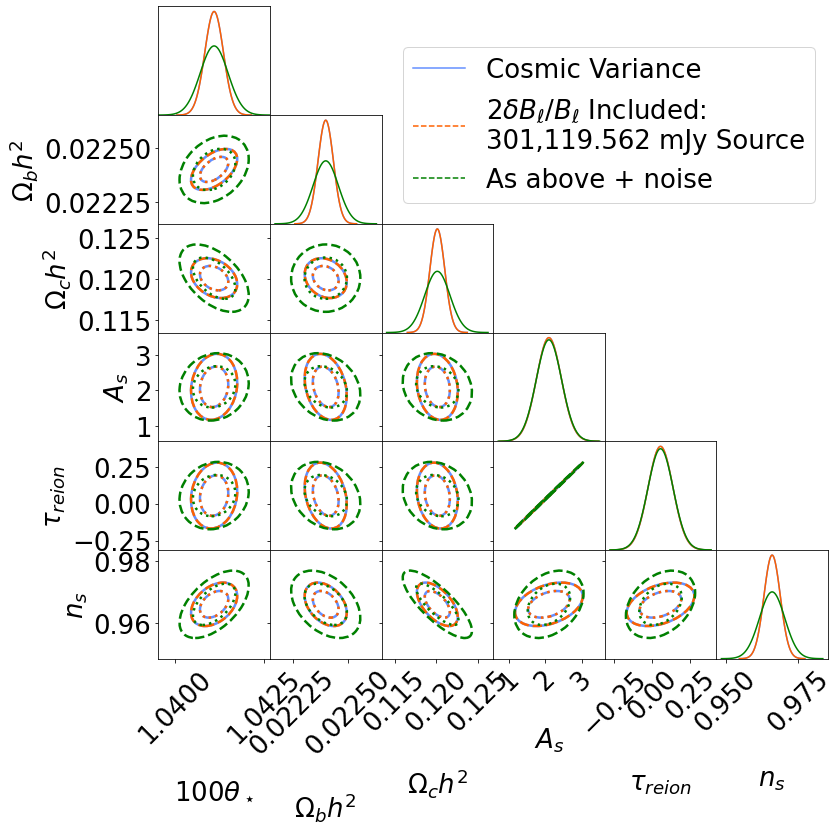

In [10]:
font = {'size'   : 26}
mpl.rc('font', **font)


Cov1 = np.array(Covp_cosvar[4])               # Cosmic Variance
Cov2 = np.array(Cp_cosvar_beams[4])           # Cosmic Variance + Good Beam
Cov3 = np.array(Cp_teg_beams[4])

plt.rcParams["figure.figsize"] = (12,12)
useable_params = [r'$100\theta_\star$', r'$\Omega_b h^2$',r'$\Omega_c h^2$', r'$A_s$', r'$\tau_{reion}$', r'$n_s$']
useable_dict = ['thetastar', 'ombh2', 'omch2', 'As', 'tau', 'ns']


PLOT_MULT = 4.

cents = []
for i in useable_dict:
    cents.append(fiducial_values[str(i)])
pars = []
for i in useable_params:
    pars.append(str(i))
scale = [1e2, 1, 1, 1e9, 1, 1]
fig, axes = Fisher.plot_triangle_base(useable_params, cents, Cov1, scales = scale, labels=useable_params,
                                         ellipse_kwargs1={'ls': '--', 'edgecolor': '#648FFF', 'lw': 2.5},
                                         ellipse_kwargs2={'ls': '-', 'edgecolor': '#648FFF', 'lw': 2.5},
                                         color_1d='#648FFF');
Fisher.plot_triangle_base(useable_params, cents, 
                             Cov2, f = fig, ax = axes, scales = scale,
                             labels = useable_params, 
                             ellipse_kwargs1={'ls': ':', 'edgecolor': '#FE6100', 'lw': 2.5},
                             ellipse_kwargs2={'ls': '--', 'edgecolor': '#FE6100', 'lw': 2.5},
                             color_1d='#FE6100');
Fisher.plot_triangle_base(useable_params, cents, 
                             Cov3, f = fig, ax = axes, scales = scale,
                             labels = useable_params, 
                             ellipse_kwargs1={'ls': ':', 'edgecolor': 'g', 'lw': 2.5},
                             ellipse_kwargs2={'ls': '--', 'edgecolor': 'g', 'lw': 2.5},
                             color_1d='g');


l1, = axes[0, -1].plot([],[],'-',color="#648FFF", label=r'Cosmic Variance');
l2, = axes[0, -1].plot([],[],'--',color="#FE6100", label= r'Cosmic Variance \n + Beam Cov');
l2, = axes[0, -1].plot([],[],'--',color="g", label= r'Cosmic Variance \n + SO Noise + Beam Cov');

labels = ['Cosmic Variance', r'$2\delta B_\ell/B_\ell$ Included:  301,119.562 mJy Source',
         r'As above + noise']

wrapped_labels = [ label.replace('  ', '\n') for label in labels ]

axes[0, -1].legend(wrapped_labels, bbox_to_anchor=(1.005, 0.75), ncol=1, fontsize = 26);
plt.subplots_adjust(wspace=0, hspace=0)